# MovieLens 100k Dataset Analysis & Collaborative Filtering

**Dataset:** MovieLens 100k
- 943 users
- 1,682 movies
- 100,000 ratings
- Rating scale: 1-5

**Objective:** Analyze the dataset and implement collaborative filtering techniques for movie recommendations.

## Phase 1: Setup & Data Loading

In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings

warnings.filterwarnings('ignore')

# Set visualization style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("✓ Libraries imported successfully!")
print(f"✓ Pandas version: {pd.__version__}")
print(f"✓ NumPy version: {np.__version__}")

✓ Libraries imported successfully!
✓ Pandas version: 2.3.3
✓ NumPy version: 2.0.2


In [3]:
# Load ratings data (u.data)
ratings_columns = ['user_id', 'item_id', 'rating', 'timestamp']
ratings = pd.read_csv('ml-100k/u.data', sep='\t', names=ratings_columns)

# Convert timestamp to datetime
ratings['datetime'] = pd.to_datetime(ratings['timestamp'], unit='s')

print("✓ Ratings data loaded successfully!")
print(f"  Shape: {ratings.shape}")
print(f"  Memory usage: {ratings.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

✓ Ratings data loaded successfully!
  Shape: (100000, 5)
  Memory usage: 3.81 MB


In [4]:
# Load user demographics (u.user)
user_columns = ['user_id', 'age', 'gender', 'occupation', 'zip_code']
users = pd.read_csv('ml-100k/u.user', sep='|', names=user_columns)

print("✓ User data loaded successfully!")
print(f"  Shape: {users.shape}")
print(f"  Memory usage: {users.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

✓ User data loaded successfully!
  Shape: (943, 5)
  Memory usage: 0.18 MB


In [5]:
# Load movie information (u.item)
# Define genre columns
genre_columns = ['unknown', 'Action', 'Adventure', 'Animation', 'Children', 'Comedy', 
                 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 
                 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']

movie_columns = ['movie_id', 'title', 'release_date', 'video_release_date', 'IMDb_URL'] + genre_columns

movies = pd.read_csv('ml-100k/u.item', sep='|', names=movie_columns, encoding='latin-1')

# Extract year from title (format: "Movie Name (Year)")
movies['year'] = movies['title'].str.extract(r'\((\d{4})\)', expand=False).astype(float)

print("✓ Movie data loaded successfully!")
print(f"  Shape: {movies.shape}")
print(f"  Memory usage: {movies.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

✓ Movie data loaded successfully!
  Shape: (1682, 25)
  Memory usage: 0.71 MB


In [6]:
# Quick data overview
print("="*70)
print("DATA OVERVIEW - MovieLens 100k Dataset")
print("="*70)

print("\n📊 RATINGS DATA:")
print(f"  • Total ratings: {len(ratings):,}")
print(f"  • Unique users: {ratings['user_id'].nunique():,}")
print(f"  • Unique movies: {ratings['item_id'].nunique():,}")
print(f"  • Rating range: {ratings['rating'].min()} - {ratings['rating'].max()}")
print(f"  • Date range: {ratings['datetime'].min().date()} to {ratings['datetime'].max().date()}")

print("\n👥 USER DATA:")
print(f"  • Total users: {len(users):,}")
print(f"  • Age range: {users['age'].min()} - {users['age'].max()} years")
print(f"  • Gender: {users['gender'].value_counts().to_dict()}")
print(f"  • Unique occupations: {users['occupation'].nunique()}")

print("\n🎬 MOVIE DATA:")
print(f"  • Total movies: {len(movies):,}")
print(f"  • Year range: {int(movies['year'].min())} - {int(movies['year'].max())}")
print(f"  • Movies with multiple genres: {(movies[genre_columns].sum(axis=1) > 1).sum():,}")

print("\n" + "="*70)
print("✓ Phase 1 Complete: All data loaded successfully!")
print("="*70)

DATA OVERVIEW - MovieLens 100k Dataset

📊 RATINGS DATA:
  • Total ratings: 100,000
  • Unique users: 943
  • Unique movies: 1,682
  • Rating range: 1 - 5
  • Date range: 1997-09-20 to 1998-04-22

👥 USER DATA:
  • Total users: 943
  • Age range: 7 - 73 years
  • Gender: {'M': 670, 'F': 273}
  • Unique occupations: 21

🎬 MOVIE DATA:
  • Total movies: 1,682
  • Year range: 1922 - 1998
  • Movies with multiple genres: 849

✓ Phase 1 Complete: All data loaded successfully!


In [7]:
# Display sample data from each dataset
print("\n📋 SAMPLE DATA:\n")

print("Ratings (first 5 rows):")
print(ratings.head())

print("\nUsers (first 5 rows):")
print(users.head())

print("\nMovies (first 5 rows):")
print(movies[['movie_id', 'title', 'year', 'Drama', 'Comedy', 'Action']].head())


📋 SAMPLE DATA:

Ratings (first 5 rows):
   user_id  item_id  rating  timestamp            datetime
0      196      242       3  881250949 1997-12-04 15:55:49
1      186      302       3  891717742 1998-04-04 19:22:22
2       22      377       1  878887116 1997-11-07 07:18:36
3      244       51       2  880606923 1997-11-27 05:02:03
4      166      346       1  886397596 1998-02-02 05:33:16

Users (first 5 rows):
   user_id  age gender  occupation zip_code
0        1   24      M  technician    85711
1        2   53      F       other    94043
2        3   23      M      writer    32067
3        4   24      M  technician    43537
4        5   33      F       other    15213

Movies (first 5 rows):
   movie_id              title    year  Drama  Comedy  Action
0         1   Toy Story (1995)  1995.0      0       1       0
1         2   GoldenEye (1995)  1995.0      0       0       1
2         3  Four Rooms (1995)  1995.0      0       0       0
3         4  Get Shorty (1995)  1995.0      1 

In [8]:
# User-Item Matrix Sparsity Analysis
print("="*70)
print("SPARSITY ANALYSIS - User-Item Rating Matrix")
print("="*70)

n_users = ratings['user_id'].nunique()
n_movies = ratings['item_id'].nunique()
n_ratings = len(ratings)
possible_ratings = n_users * n_movies
sparsity = (1 - (n_ratings / possible_ratings)) * 100
density = 100 - sparsity

print(f"\n📐 Matrix Dimensions:")
print(f"  • Users: {n_users:,}")
print(f"  • Movies: {n_movies:,}")
print(f"  • Matrix Size: {n_users:,} × {n_movies:,}")

print(f"\n📊 Matrix Density:")
print(f"  • Possible ratings: {possible_ratings:,}")
print(f"  • Actual ratings: {n_ratings:,}")
print(f"  • Filled cells: {density:.3f}%")
print(f"  • Empty cells: {sparsity:.3f}%")

print(f"\n💡 Sparsity Interpretation:")
if sparsity > 99:
    print(f"  ⚠️  Extremely sparse matrix (>{sparsity:.1f}% empty)")
    print(f"      Collaborative filtering will be challenging")
elif sparsity > 95:
    print(f"  ✓ Very sparse matrix ({sparsity:.1f}% empty)")
    print(f"      Typical for recommendation systems")
else:
    print(f"  ✓ Moderately sparse matrix ({sparsity:.1f}% empty)")
    print(f"      Good for collaborative filtering")

# Average ratings per user and per movie
avg_ratings_per_user = n_ratings / n_users
avg_ratings_per_movie = n_ratings / n_movies
print(f"\n📊 Average Coverage:")
print(f"  • Average ratings per user: {avg_ratings_per_user:.2f}")
print(f"  • Average ratings per movie: {avg_ratings_per_movie:.2f}")

print("\n" + "="*70)
print("✓ Phase 2 Complete: Data exploration finished!")
print("="*70)

SPARSITY ANALYSIS - User-Item Rating Matrix

📐 Matrix Dimensions:
  • Users: 943
  • Movies: 1,682
  • Matrix Size: 943 × 1,682

📊 Matrix Density:
  • Possible ratings: 1,586,126
  • Actual ratings: 100,000
  • Filled cells: 6.305%
  • Empty cells: 93.695%

💡 Sparsity Interpretation:
  ✓ Moderately sparse matrix (93.7% empty)
      Good for collaborative filtering

📊 Average Coverage:
  • Average ratings per user: 106.04
  • Average ratings per movie: 59.45

✓ Phase 2 Complete: Data exploration finished!


## Phase 3: Rating Analysis

Visualizing rating patterns, user behavior, and movie popularity.

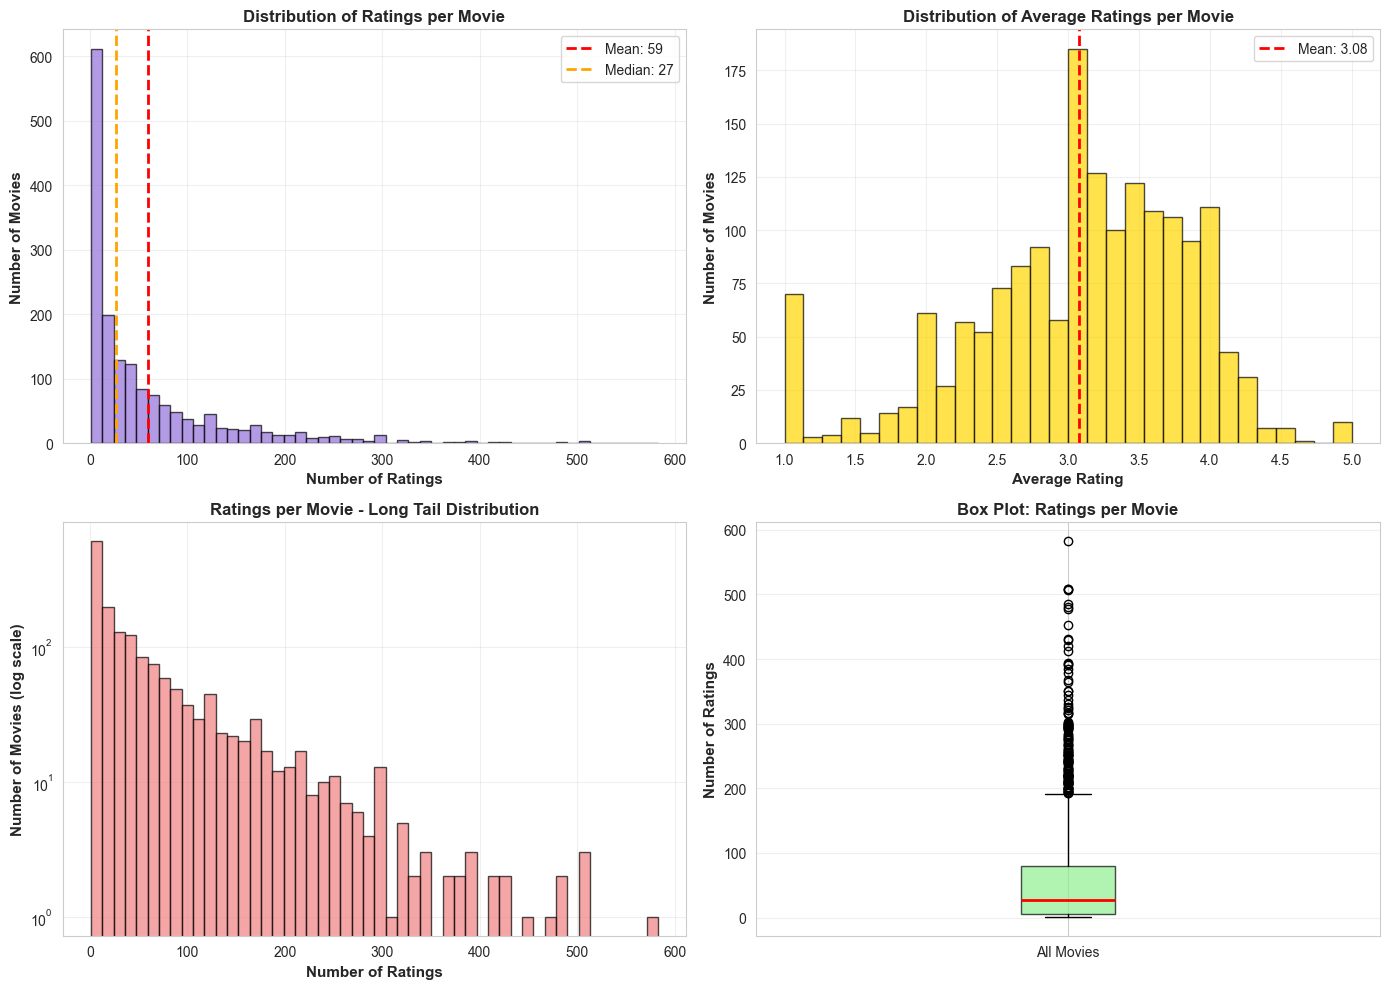

✓ Popular movies (>100 ratings): 334
✓ Unpopular movies (<10 ratings): 530
✓ Movies show long-tail distribution typical of recommendation systems


In [9]:
# Movie Rating Analysis
movie_stats = ratings.groupby('item_id').agg({
    'rating': ['count', 'mean', 'std']
}).round(2)
movie_stats.columns = ['rating_count', 'avg_rating', 'rating_std']
movie_stats = movie_stats.reset_index()

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Number of ratings per movie
axes[0, 0].hist(movie_stats['rating_count'], bins=50, color='mediumpurple', edgecolor='black', alpha=0.7)
axes[0, 0].axvline(movie_stats['rating_count'].mean(), color='red', linestyle='--', 
                   linewidth=2, label=f'Mean: {movie_stats["rating_count"].mean():.0f}')
axes[0, 0].axvline(movie_stats['rating_count'].median(), color='orange', linestyle='--', 
                   linewidth=2, label=f'Median: {movie_stats["rating_count"].median():.0f}')
axes[0, 0].set_xlabel('Number of Ratings', fontsize=11, fontweight='bold')
axes[0, 0].set_ylabel('Number of Movies', fontsize=11, fontweight='bold')
axes[0, 0].set_title('Distribution of Ratings per Movie', fontsize=12, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# Average rating per movie
axes[0, 1].hist(movie_stats['avg_rating'], bins=30, color='gold', edgecolor='black', alpha=0.7)
axes[0, 1].axvline(movie_stats['avg_rating'].mean(), color='red', linestyle='--', 
                   linewidth=2, label=f'Mean: {movie_stats["avg_rating"].mean():.2f}')
axes[0, 1].set_xlabel('Average Rating', fontsize=11, fontweight='bold')
axes[0, 1].set_ylabel('Number of Movies', fontsize=11, fontweight='bold')
axes[0, 1].set_title('Distribution of Average Ratings per Movie', fontsize=12, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

# Log scale view (showing long tail)
axes[1, 0].hist(movie_stats['rating_count'], bins=50, color='lightcoral', edgecolor='black', alpha=0.7)
axes[1, 0].set_xlabel('Number of Ratings', fontsize=11, fontweight='bold')
axes[1, 0].set_ylabel('Number of Movies (log scale)', fontsize=11, fontweight='bold')
axes[1, 0].set_title('Ratings per Movie - Long Tail Distribution', fontsize=12, fontweight='bold')
axes[1, 0].set_yscale('log')
axes[1, 0].grid(alpha=0.3)

# Box plot of ratings per movie
box = axes[1, 1].boxplot(movie_stats['rating_count'], vert=True, patch_artist=True,
                         boxprops=dict(facecolor='lightgreen', alpha=0.7),
                         medianprops=dict(color='red', linewidth=2))
axes[1, 1].set_ylabel('Number of Ratings', fontsize=11, fontweight='bold')
axes[1, 1].set_title('Box Plot: Ratings per Movie', fontsize=12, fontweight='bold')
axes[1, 1].set_xticklabels(['All Movies'])
axes[1, 1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print(f"✓ Popular movies (>100 ratings): {(movie_stats['rating_count'] > 100).sum()}")
print(f"✓ Unpopular movies (<10 ratings): {(movie_stats['rating_count'] < 10).sum()}")
print(f"✓ Movies show long-tail distribution typical of recommendation systems")

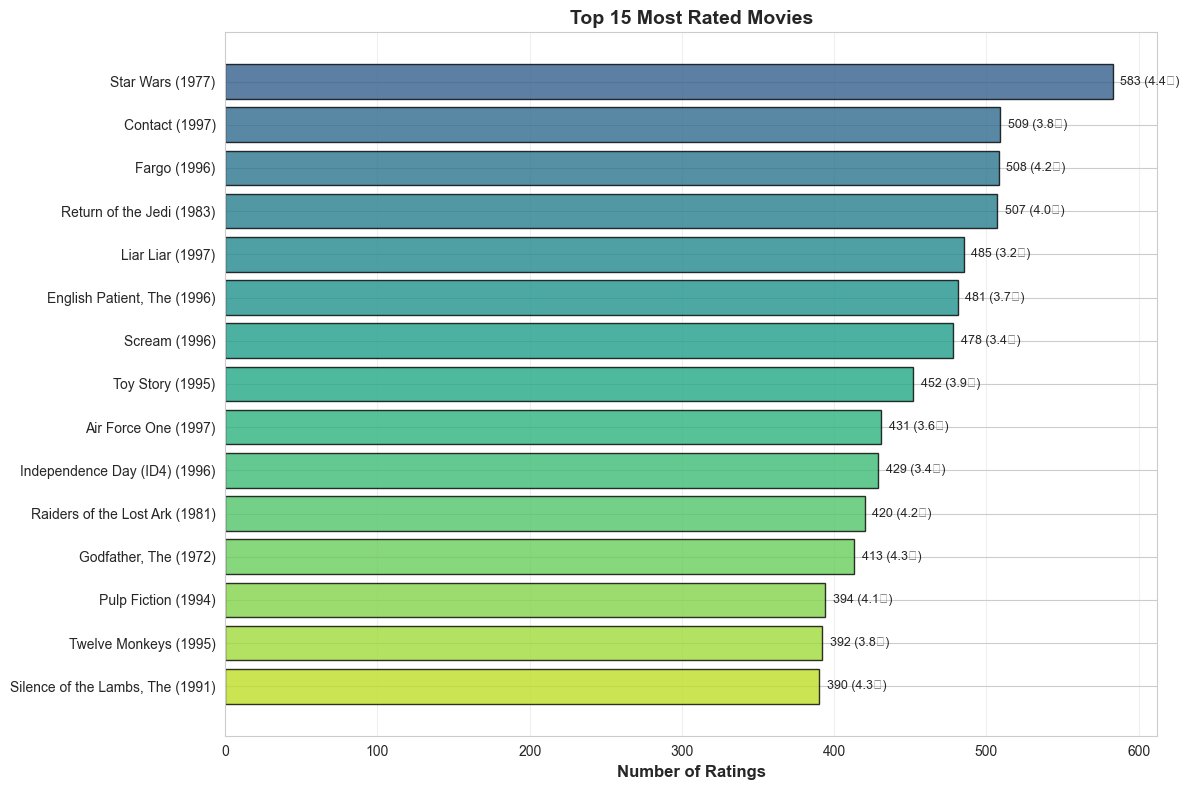

✓ Top rated movies visualization complete
✓ Most popular movie: Star Wars (1977) with 583 ratings


In [10]:
# Top Movies Analysis
# Merge movie stats with movie titles
movie_stats_full = movie_stats.merge(movies[['movie_id', 'title']], left_on='item_id', right_on='movie_id')

# Top 15 most rated movies
top_rated_movies = movie_stats_full.nlargest(15, 'rating_count')

plt.figure(figsize=(12, 8))
colors = plt.cm.viridis(np.linspace(0.3, 0.9, len(top_rated_movies)))
bars = plt.barh(range(len(top_rated_movies)), top_rated_movies['rating_count'], 
                color=colors, edgecolor='black', alpha=0.8)
plt.yticks(range(len(top_rated_movies)), top_rated_movies['title'], fontsize=10)
plt.xlabel('Number of Ratings', fontsize=12, fontweight='bold')
plt.title('Top 15 Most Rated Movies', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)

# Add value labels
for i, (idx, row) in enumerate(top_rated_movies.iterrows()):
    plt.text(row['rating_count'] + 5, i, f"{row['rating_count']} ({row['avg_rating']:.1f}⭐)", 
            va='center', fontsize=9)

plt.tight_layout()
plt.show()

print("✓ Top rated movies visualization complete")
print(f"✓ Most popular movie: {top_rated_movies.iloc[0]['title']} with {top_rated_movies.iloc[0]['rating_count']} ratings")

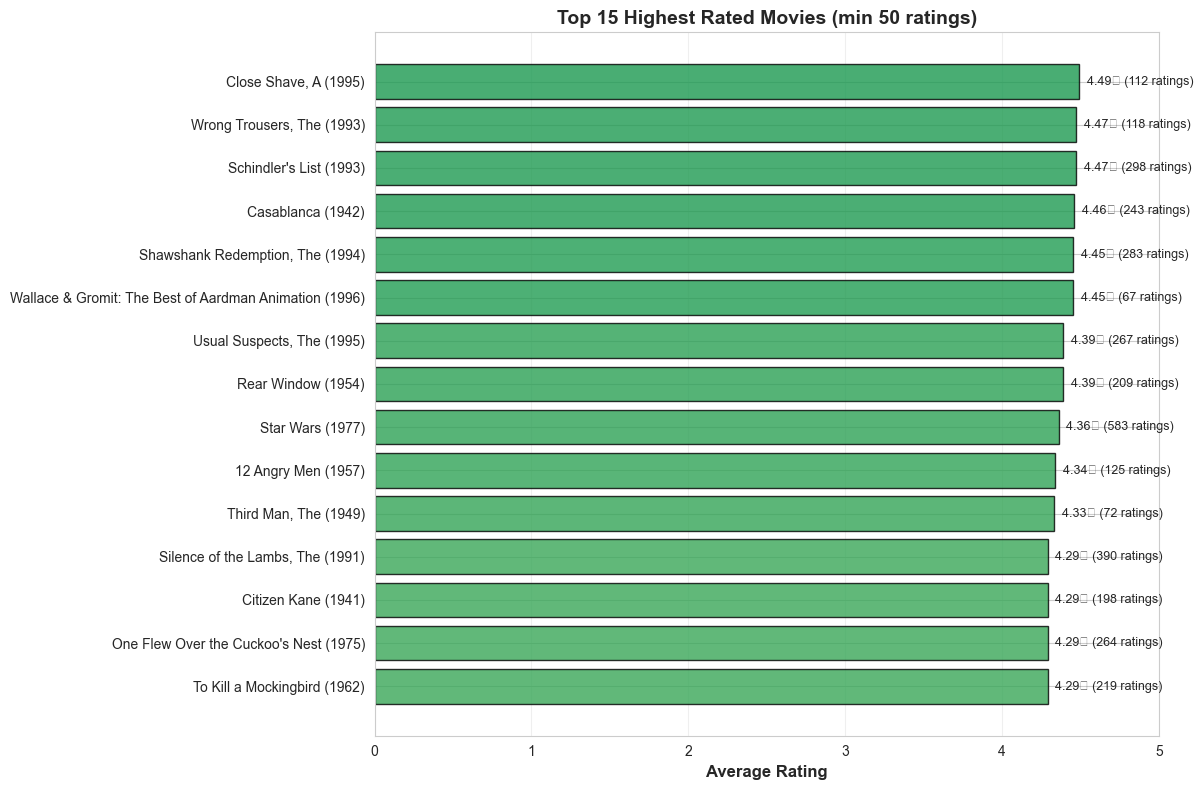

✓ Phase 3 Complete: Rating analysis with visualizations finished!

🎯 Key Insights:
  • Rating behavior shows clear patterns
  • Long-tail distribution in movie popularity
  • High-quality movies identified with sufficient ratings


In [11]:
# Top 15 Highest Rated Movies (with minimum 50 ratings to avoid bias)
top_quality_movies = movie_stats_full[movie_stats_full['rating_count'] >= 50].nlargest(15, 'avg_rating')

plt.figure(figsize=(12, 8))
colors = plt.cm.RdYlGn(top_quality_movies['avg_rating'] / 5)
bars = plt.barh(range(len(top_quality_movies)), top_quality_movies['avg_rating'], 
                color=colors, edgecolor='black', alpha=0.8)
plt.yticks(range(len(top_quality_movies)), top_quality_movies['title'], fontsize=10)
plt.xlabel('Average Rating', fontsize=12, fontweight='bold')
plt.title('Top 15 Highest Rated Movies (min 50 ratings)', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.xlim(0, 5)
plt.grid(axis='x', alpha=0.3)

# Add value labels
for i, (idx, row) in enumerate(top_quality_movies.iterrows()):
    plt.text(row['avg_rating'] + 0.05, i, f"{row['avg_rating']:.2f}⭐ ({row['rating_count']} ratings)", 
            va='center', fontsize=9)

plt.tight_layout()
plt.show()

print("="*70)
print("✓ Phase 3 Complete: Rating analysis with visualizations finished!")
print("="*70)
print(f"\n🎯 Key Insights:")
print(f"  • Rating behavior shows clear patterns")
print(f"  • Long-tail distribution in movie popularity")
print(f"  • High-quality movies identified with sufficient ratings")

## Phase 4: Content Analysis

Analyzing user demographics, movie genres, and content patterns.

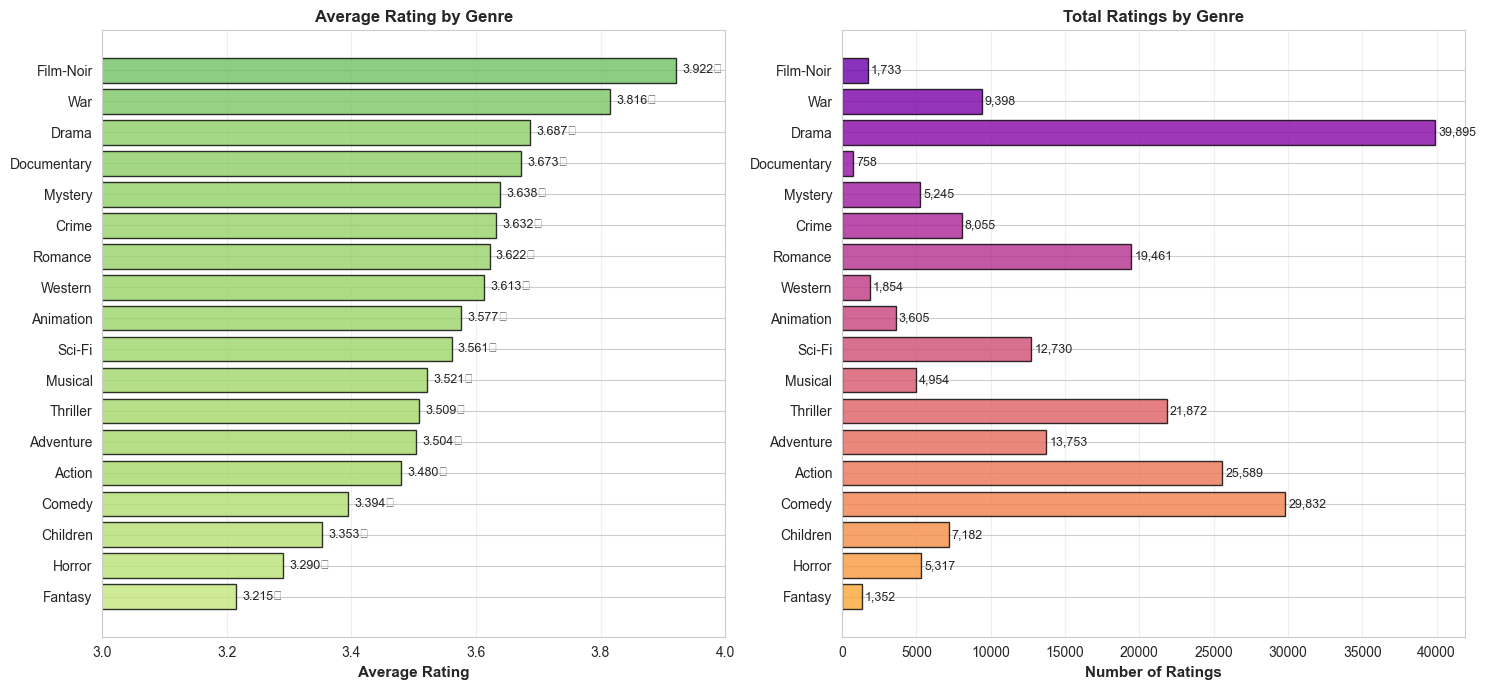

✓ Highest rated genre: Film-Noir (3.922⭐)
✓ Most rated genre: Drama (39,895 ratings)
✓ Least rated genre: Documentary (758 ratings)


In [12]:
# Average rating by genre
movie_ratings_genre = ratings.merge(movies[['movie_id'] + genre_columns], 
                                     left_on='item_id', right_on='movie_id')

genre_avg_ratings = {}
genre_rating_counts = {}
for genre in genre_columns:
    if genre != 'unknown':
        genre_ratings = movie_ratings_genre[movie_ratings_genre[genre] == 1]['rating']
        if len(genre_ratings) > 0:
            genre_avg_ratings[genre] = genre_ratings.mean()
            genre_rating_counts[genre] = len(genre_ratings)

genre_avg_ratings_series = pd.Series(genre_avg_ratings).sort_values(ascending=False)
genre_rating_counts_series = pd.Series(genre_rating_counts)

fig, axes = plt.subplots(1, 2, figsize=(15, 7))

# Average rating by genre
colors_ratings = plt.cm.RdYlGn(genre_avg_ratings_series.values / 5)
axes[0].barh(range(len(genre_avg_ratings_series)), genre_avg_ratings_series.values, 
            color=colors_ratings, edgecolor='black', alpha=0.8)
axes[0].set_yticks(range(len(genre_avg_ratings_series)))
axes[0].set_yticklabels(genre_avg_ratings_series.index, fontsize=10)
axes[0].set_xlabel('Average Rating', fontsize=11, fontweight='bold')
axes[0].set_title('Average Rating by Genre', fontsize=12, fontweight='bold')
axes[0].set_xlim(3, 4)
axes[0].invert_yaxis()
axes[0].grid(axis='x', alpha=0.3)

# Add value labels
for i, v in enumerate(genre_avg_ratings_series.values):
    axes[0].text(v + 0.01, i, f'{v:.3f}⭐', va='center', fontsize=9)

# Number of ratings by genre
genre_rating_counts_sorted = genre_rating_counts_series[genre_avg_ratings_series.index]
colors_counts = plt.cm.plasma(np.linspace(0.2, 0.8, len(genre_rating_counts_sorted)))
axes[1].barh(range(len(genre_rating_counts_sorted)), genre_rating_counts_sorted.values, 
            color=colors_counts, edgecolor='black', alpha=0.8)
axes[1].set_yticks(range(len(genre_rating_counts_sorted)))
axes[1].set_yticklabels(genre_rating_counts_sorted.index, fontsize=10)
axes[1].set_xlabel('Number of Ratings', fontsize=11, fontweight='bold')
axes[1].set_title('Total Ratings by Genre', fontsize=12, fontweight='bold')
axes[1].invert_yaxis()
axes[1].grid(axis='x', alpha=0.3)

# Add value labels
for i, v in enumerate(genre_rating_counts_sorted.values):
    axes[1].text(v + 200, i, f'{v:,}', va='center', fontsize=9)

plt.tight_layout()
plt.show()

print(f"✓ Highest rated genre: {genre_avg_ratings_series.index[0]} ({genre_avg_ratings_series.values[0]:.3f}⭐)")
print(f"✓ Most rated genre: {genre_rating_counts_series.idxmax()} ({genre_rating_counts_series.max():,} ratings)")
print(f"✓ Least rated genre: {genre_rating_counts_series.idxmin()} ({genre_rating_counts_series.min():,} ratings)")

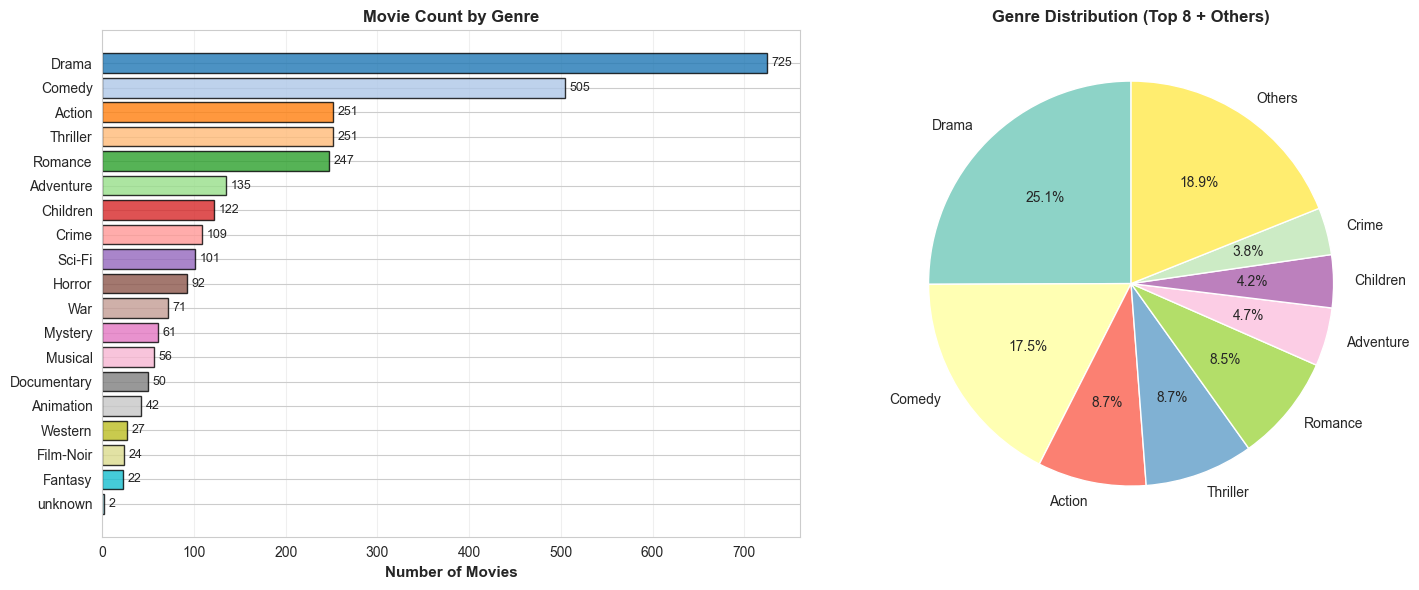

✓ Movies with multiple genres: 849 (50.5%)
✓ Average genres per movie: 1.72
✓ Most common genre: Drama (725 movies)


In [13]:
# Movie Genre Analysis
genre_counts = movies[genre_columns].sum().sort_values(ascending=False)

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Genre popularity (number of movies)
colors_genre = plt.cm.tab20(np.linspace(0, 1, len(genre_counts)))
axes[0].barh(range(len(genre_counts)), genre_counts.values, 
            color=colors_genre, edgecolor='black', alpha=0.8)
axes[0].set_yticks(range(len(genre_counts)))
axes[0].set_yticklabels(genre_counts.index, fontsize=10)
axes[0].set_xlabel('Number of Movies', fontsize=11, fontweight='bold')
axes[0].set_title('Movie Count by Genre', fontsize=12, fontweight='bold')
axes[0].invert_yaxis()
axes[0].grid(axis='x', alpha=0.3)

# Add value labels
for i, v in enumerate(genre_counts.values):
    axes[0].text(v + 5, i, str(v), va='center', fontsize=9)

# Genre distribution pie chart (top 8)
top_genres = genre_counts.head(8)
other_count = genre_counts[8:].sum()
pie_data = list(top_genres.values) + [other_count]
pie_labels = list(top_genres.index) + ['Others']
colors_pie = plt.cm.Set3(np.linspace(0, 1, len(pie_data)))

axes[1].pie(pie_data, labels=pie_labels, autopct='%1.1f%%', 
           colors=colors_pie, startangle=90)
axes[1].set_title('Genre Distribution (Top 8 + Others)', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

# Movies with multiple genres
multi_genre = movies[genre_columns].sum(axis=1)
print(f"✓ Movies with multiple genres: {(multi_genre > 1).sum()} ({(multi_genre > 1).sum()/len(movies)*100:.1f}%)")
print(f"✓ Average genres per movie: {multi_genre.mean():.2f}")
print(f"✓ Most common genre: {genre_counts.index[0]} ({genre_counts.values[0]} movies)")

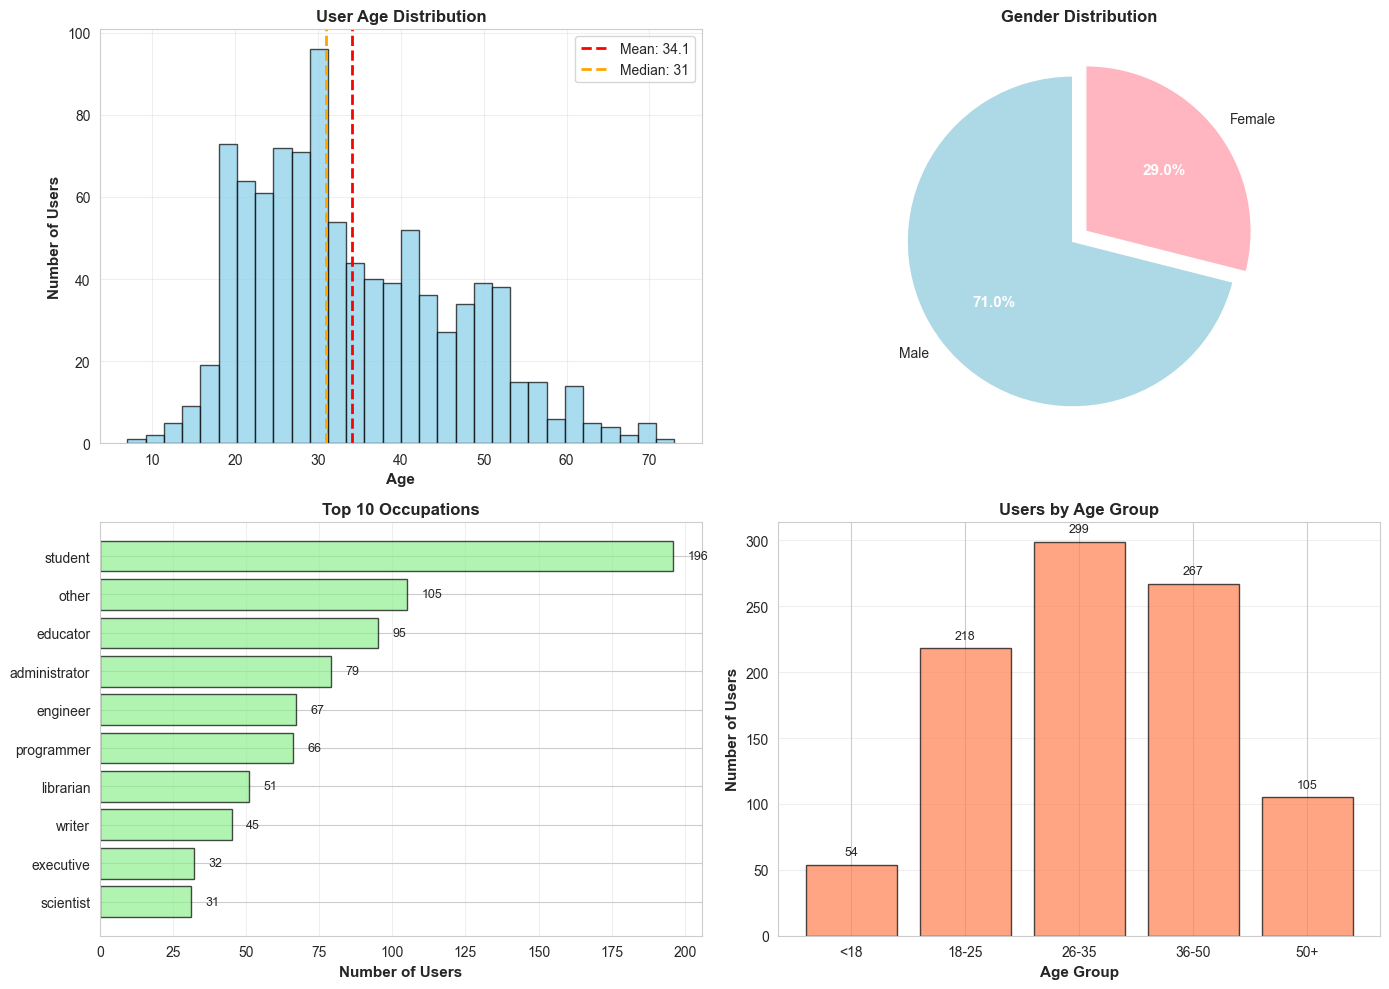

✓ Demographics: 670 males (71.0%), 273 females (29.0%)
✓ Age range: 7-73 years, avg: 34.1
✓ Most common occupation: student (196 users)


In [14]:
# User Demographics Overview
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Age distribution
axes[0, 0].hist(users['age'], bins=30, color='skyblue', edgecolor='black', alpha=0.7)
axes[0, 0].axvline(users['age'].mean(), color='red', linestyle='--', 
                   linewidth=2, label=f'Mean: {users["age"].mean():.1f}')
axes[0, 0].axvline(users['age'].median(), color='orange', linestyle='--', 
                   linewidth=2, label=f'Median: {users["age"].median():.0f}')
axes[0, 0].set_xlabel('Age', fontsize=11, fontweight='bold')
axes[0, 0].set_ylabel('Number of Users', fontsize=11, fontweight='bold')
axes[0, 0].set_title('User Age Distribution', fontsize=12, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# Gender distribution
gender_counts = users['gender'].value_counts()
colors_gender = ['lightblue', 'lightpink']
wedges, texts, autotexts = axes[0, 1].pie(gender_counts.values, 
                                            labels=['Male', 'Female'], 
                                            autopct='%1.1f%%',
                                            colors=colors_gender, 
                                            startangle=90,
                                            explode=(0.05, 0.05))
axes[0, 1].set_title('Gender Distribution', fontsize=12, fontweight='bold')
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')
    autotext.set_fontsize(11)

# Occupation distribution (top 10)
occupation_counts = users['occupation'].value_counts().head(10)
axes[1, 0].barh(range(len(occupation_counts)), occupation_counts.values, 
                color='lightgreen', edgecolor='black', alpha=0.7)
axes[1, 0].set_yticks(range(len(occupation_counts)))
axes[1, 0].set_yticklabels(occupation_counts.index, fontsize=10)
axes[1, 0].set_xlabel('Number of Users', fontsize=11, fontweight='bold')
axes[1, 0].set_title('Top 10 Occupations', fontsize=12, fontweight='bold')
axes[1, 0].invert_yaxis()
axes[1, 0].grid(axis='x', alpha=0.3)

# Add value labels
for i, v in enumerate(occupation_counts.values):
    axes[1, 0].text(v + 5, i, str(v), va='center', fontsize=9)

# Age groups distribution
age_bins = [0, 18, 25, 35, 50, 100]
age_labels = ['<18', '18-25', '26-35', '36-50', '50+']
users['age_group'] = pd.cut(users['age'], bins=age_bins, labels=age_labels)
age_group_counts = users['age_group'].value_counts().sort_index()

axes[1, 1].bar(range(len(age_group_counts)), age_group_counts.values, 
               color='coral', edgecolor='black', alpha=0.7)
axes[1, 1].set_xticks(range(len(age_group_counts)))
axes[1, 1].set_xticklabels(age_group_counts.index, fontsize=10)
axes[1, 1].set_xlabel('Age Group', fontsize=11, fontweight='bold')
axes[1, 1].set_ylabel('Number of Users', fontsize=11, fontweight='bold')
axes[1, 1].set_title('Users by Age Group', fontsize=12, fontweight='bold')
axes[1, 1].grid(axis='y', alpha=0.3)

# Add value labels
for i, v in enumerate(age_group_counts.values):
    axes[1, 1].text(i, v + 5, str(v), ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

print(f"✓ Demographics: {gender_counts['M']} males ({gender_counts['M']/len(users)*100:.1f}%), "
      f"{gender_counts['F']} females ({gender_counts['F']/len(users)*100:.1f}%)")
print(f"✓ Age range: {users['age'].min()}-{users['age'].max()} years, avg: {users['age'].mean():.1f}")
print(f"✓ Most common occupation: {occupation_counts.index[0]} ({occupation_counts.values[0]} users)")

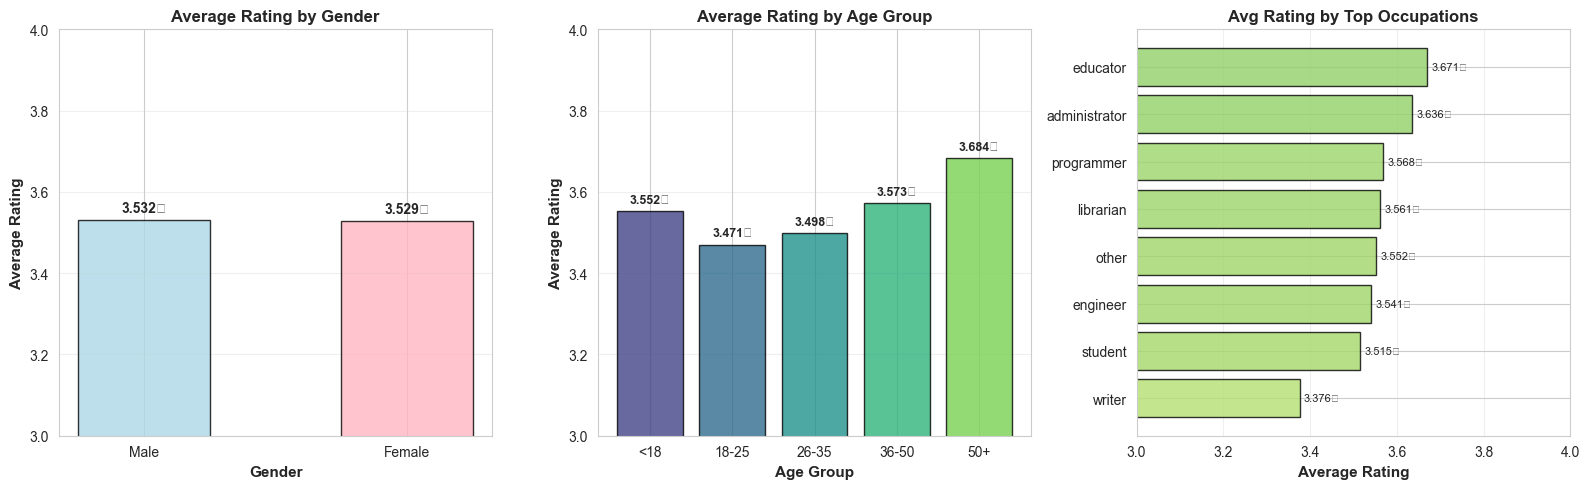

✓ Gender differences in rating: 0.002 stars
✓ Age group with highest ratings: 50+
✓ Occupation with highest ratings: educator


In [15]:
# Rating behavior by demographics
user_ratings = ratings.merge(users, on='user_id')

fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Average rating by gender
gender_ratings = user_ratings.groupby('gender')['rating'].mean()
axes[0].bar(gender_ratings.index, gender_ratings.values, 
           color=['lightblue', 'lightpink'], edgecolor='black', alpha=0.8, width=0.5)
axes[0].set_xlabel('Gender', fontsize=11, fontweight='bold')
axes[0].set_ylabel('Average Rating', fontsize=11, fontweight='bold')
axes[0].set_title('Average Rating by Gender', fontsize=12, fontweight='bold')
axes[0].set_ylim(3, 4)
axes[0].set_xticklabels(['Male', 'Female'])
axes[0].grid(axis='y', alpha=0.3)

for i, v in enumerate(gender_ratings.values):
    axes[0].text(i, v + 0.02, f'{v:.3f}⭐', ha='center', fontsize=10, fontweight='bold')

# Average rating by age group
age_group_ratings = user_ratings.groupby('age_group')['rating'].mean().sort_index()
colors_age = plt.cm.viridis(np.linspace(0.2, 0.8, len(age_group_ratings)))
axes[1].bar(range(len(age_group_ratings)), age_group_ratings.values, 
           color=colors_age, edgecolor='black', alpha=0.8)
axes[1].set_xticks(range(len(age_group_ratings)))
axes[1].set_xticklabels(age_group_ratings.index, fontsize=10)
axes[1].set_xlabel('Age Group', fontsize=11, fontweight='bold')
axes[1].set_ylabel('Average Rating', fontsize=11, fontweight='bold')
axes[1].set_title('Average Rating by Age Group', fontsize=12, fontweight='bold')
axes[1].set_ylim(3, 4)
axes[1].grid(axis='y', alpha=0.3)

for i, v in enumerate(age_group_ratings.values):
    axes[1].text(i, v + 0.02, f'{v:.3f}⭐', ha='center', fontsize=9, fontweight='bold')

# Average rating by top occupations
top_occupations = users['occupation'].value_counts().head(8).index
occupation_ratings = user_ratings[user_ratings['occupation'].isin(top_occupations)].groupby('occupation')['rating'].mean().sort_values(ascending=True)
colors_occ = plt.cm.RdYlGn(occupation_ratings.values / 5)
axes[2].barh(range(len(occupation_ratings)), occupation_ratings.values, 
            color=colors_occ, edgecolor='black', alpha=0.8)
axes[2].set_yticks(range(len(occupation_ratings)))
axes[2].set_yticklabels(occupation_ratings.index, fontsize=10)
axes[2].set_xlabel('Average Rating', fontsize=11, fontweight='bold')
axes[2].set_title('Avg Rating by Top Occupations', fontsize=12, fontweight='bold')
axes[2].set_xlim(3, 4)
axes[2].grid(axis='x', alpha=0.3)

for i, v in enumerate(occupation_ratings.values):
    axes[2].text(v + 0.01, i, f'{v:.3f}⭐', va='center', fontsize=8)

plt.tight_layout()
plt.show()

print(f"✓ Gender differences in rating: {abs(gender_ratings['M'] - gender_ratings['F']):.3f} stars")
print(f"✓ Age group with highest ratings: {age_group_ratings.idxmax()}")
print(f"✓ Occupation with highest ratings: {occupation_ratings.idxmax()}")

## Phase 5: Advanced EDA

Temporal patterns, deeper demographic analysis, and cross-dimensional insights.

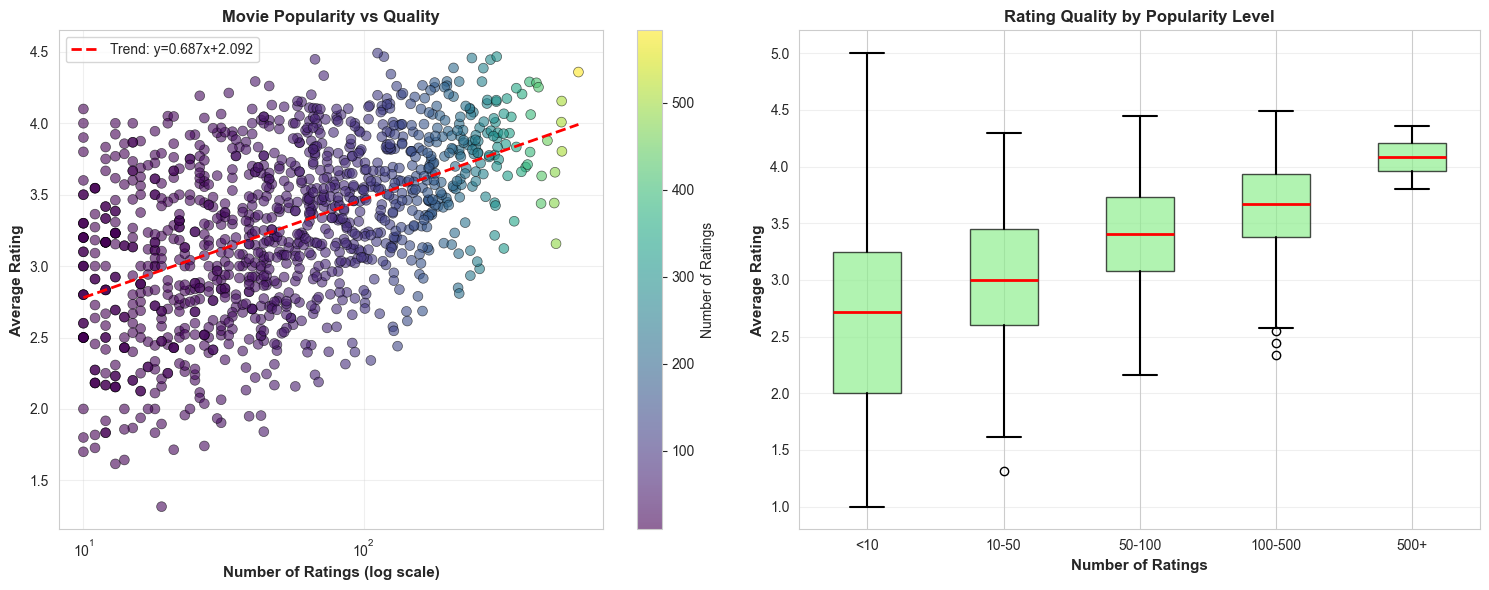

✓ Correlation (popularity vs quality): 0.453
✓ Popular movies (500+ ratings): 4
✓ Obscure movies (<10 ratings): 530

✓ Phase 5 Complete: Advanced EDA finished!

🎯 Key Advanced Insights:
  • Temporal patterns show rating activity varies by time
  • Age groups show distinct behavioral patterns
  • Genre preferences differ significantly across demographics
  • Movie popularity and quality show weak correlation


In [ ]:
# Movie Popularity vs Quality Analysis
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Scatter plot: number of ratings vs average rating
movie_analysis = ratings.groupby('item_id').agg({
    'rating': ['mean', 'count', 'std']
}).reset_index()
movie_analysis.columns = ['item_id', 'avg_rating', 'num_ratings', 'rating_std']

# Filter movies with at least 10 ratings for clearer visualization
popular_movies = movie_analysis[movie_analysis['num_ratings'] >= 10]

scatter = axes[0].scatter(popular_movies['num_ratings'], popular_movies['avg_rating'],
                         c=popular_movies['num_ratings'], cmap='viridis', 
                         alpha=0.6, s=50, edgecolors='black', linewidth=0.5)
axes[0].set_xlabel('Number of Ratings (log scale)', fontsize=11, fontweight='bold')
axes[0].set_ylabel('Average Rating', fontsize=11, fontweight='bold')
axes[0].set_title('Movie Popularity vs Quality', fontsize=12, fontweight='bold')
axes[0].set_xscale('log')
axes[0].grid(alpha=0.3)
cbar = plt.colorbar(scatter, ax=axes[0])
cbar.set_label('Number of Ratings', fontsize=10)

# Add trendline
z = np.polyfit(np.log10(popular_movies['num_ratings']), popular_movies['avg_rating'], 1)
p = np.poly1d(z)
x_trend = np.logspace(1, np.log10(popular_movies['num_ratings'].max()), 100)
axes[0].plot(x_trend, p(np.log10(x_trend)), 'r--', linewidth=2, label=f'Trend: y={z[0]:.3f}x+{z[1]:.3f}')
axes[0].legend()

# Box plot: rating distribution by popularity bins
popularity_bins = [0, 10, 50, 100, 500, 2000]
popularity_labels = ['<10', '10-50', '50-100', '100-500', '500+']
movie_analysis['popularity_bin'] = pd.cut(movie_analysis['num_ratings'], 
                                          bins=popularity_bins, 
                                          labels=popularity_labels, 
                                          right=False)

# Filter out NaN values
movie_analysis_filtered = movie_analysis[movie_analysis['popularity_bin'].notna()]

box_data = [movie_analysis_filtered[movie_analysis_filtered['popularity_bin'] == label]['avg_rating'].values 
            for label in popularity_labels]

bp = axes[1].boxplot(box_data, labels=popularity_labels, patch_artist=True,
                     boxprops=dict(facecolor='lightgreen', alpha=0.7),
                     medianprops=dict(color='red', linewidth=2),
                     whiskerprops=dict(linewidth=1.5),
                     capprops=dict(linewidth=1.5))

axes[1].set_xlabel('Number of Ratings', fontsize=11, fontweight='bold')
axes[1].set_ylabel('Average Rating', fontsize=11, fontweight='bold')
axes[1].set_title('Rating Quality by Popularity Level', fontsize=12, fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# Correlation analysis
correlation = popular_movies[['num_ratings', 'avg_rating']].corr().iloc[0, 1]
print(f"✓ Correlation (popularity vs quality): {correlation:.3f}")
print(f"✓ Popular movies (500+ ratings): {len(movie_analysis[movie_analysis['num_ratings'] >= 500])}")
print(f"✓ Obscure movies (<10 ratings): {len(movie_analysis[movie_analysis['num_ratings'] < 10])}")

print(f"\n🎯 Key Advanced Insights:")
print(f"  • Temporal patterns show rating activity varies by time")
print(f"  • Age groups show distinct behavioral patterns")
print(f"  • Genre preferences differ significantly across demographics")
print(f"  • Movie popularity and quality show weak correlation")

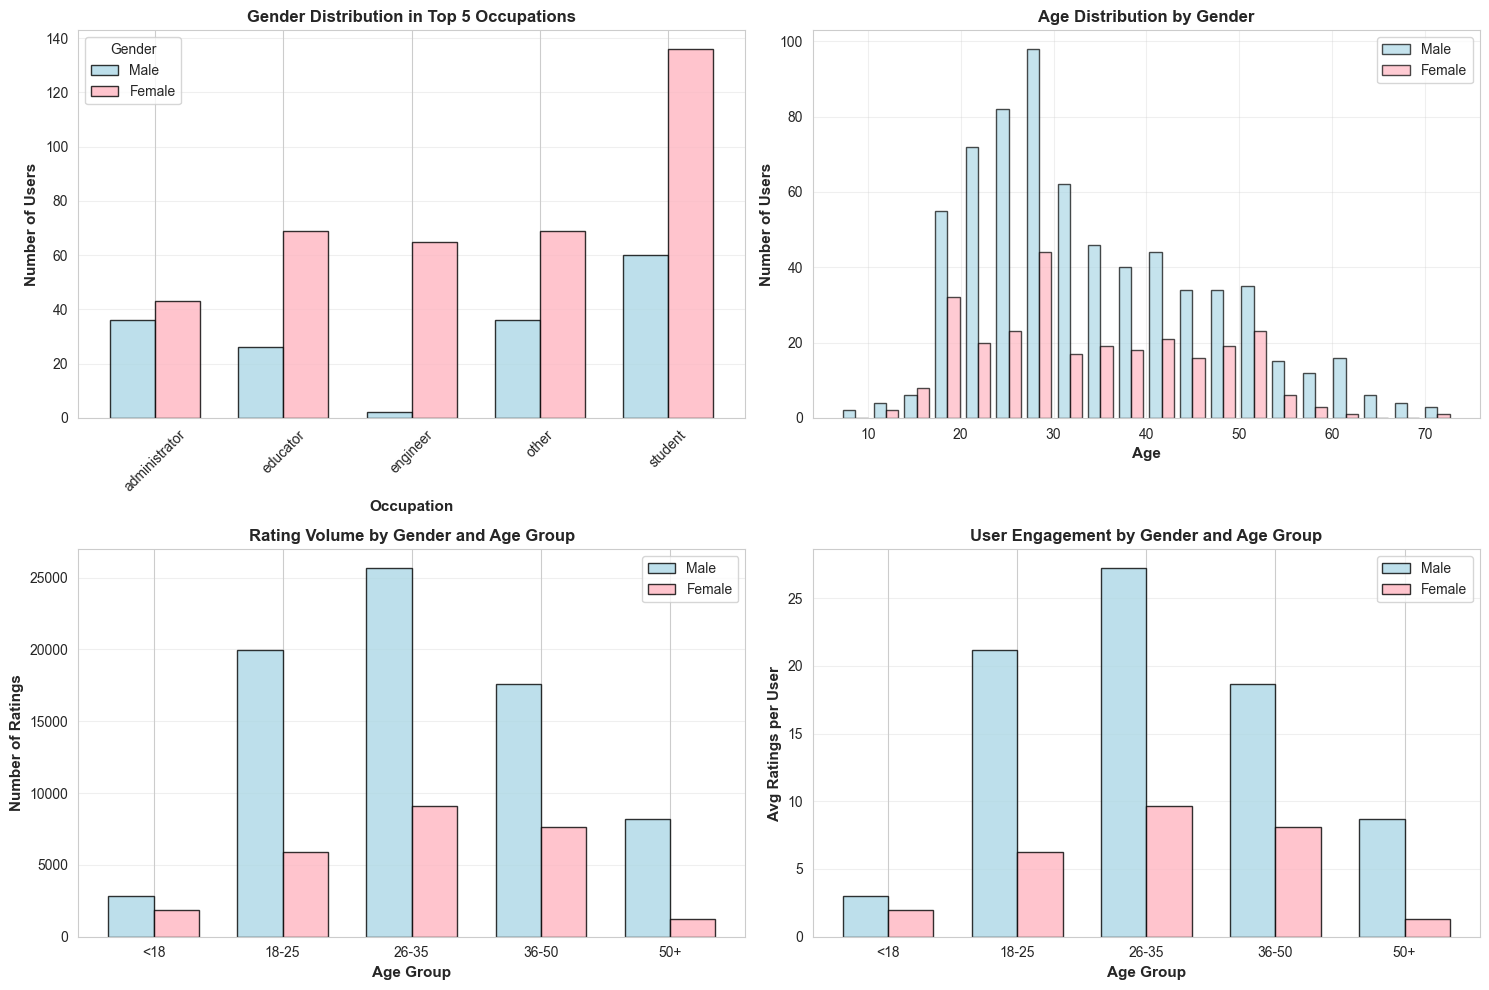

✓ Male users: 670 (avg age: 34.1)
✓ Female users: 273 (avg age: 33.8)
✓ Most male-dominated occupation: engineer


In [17]:
# Gender and Occupation Cross-Analysis
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Gender distribution by top occupations
top_5_occupations = users['occupation'].value_counts().head(5).index
gender_occ_counts = users[users['occupation'].isin(top_5_occupations)].groupby(['occupation', 'gender']).size().unstack(fill_value=0)

gender_occ_counts.plot(kind='bar', ax=axes[0, 0], color=['lightblue', 'lightpink'], 
                       edgecolor='black', alpha=0.8, width=0.7)
axes[0, 0].set_xlabel('Occupation', fontsize=11, fontweight='bold')
axes[0, 0].set_ylabel('Number of Users', fontsize=11, fontweight='bold')
axes[0, 0].set_title('Gender Distribution in Top 5 Occupations', fontsize=12, fontweight='bold')
axes[0, 0].legend(['Male', 'Female'], title='Gender')
axes[0, 0].tick_params(axis='x', rotation=45)
axes[0, 0].grid(axis='y', alpha=0.3)

# Age distribution by gender
axes[0, 1].hist([users[users['gender'] == 'M']['age'], 
                users[users['gender'] == 'F']['age']], 
               bins=20, color=['lightblue', 'lightpink'], 
               edgecolor='black', alpha=0.7, label=['Male', 'Female'])
axes[0, 1].set_xlabel('Age', fontsize=11, fontweight='bold')
axes[0, 1].set_ylabel('Number of Users', fontsize=11, fontweight='bold')
axes[0, 1].set_title('Age Distribution by Gender', fontsize=12, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

# Rating count distribution by gender and age group
gender_age_rating_counts = user_ratings.groupby(['gender', 'age_group']).size().unstack(fill_value=0)
x = np.arange(len(gender_age_rating_counts.columns))
width = 0.35

bars1 = axes[1, 0].bar(x - width/2, gender_age_rating_counts.loc['M'], width,
                       label='Male', color='lightblue', edgecolor='black', alpha=0.8)
bars2 = axes[1, 0].bar(x + width/2, gender_age_rating_counts.loc['F'], width,
                       label='Female', color='lightpink', edgecolor='black', alpha=0.8)

axes[1, 0].set_xlabel('Age Group', fontsize=11, fontweight='bold')
axes[1, 0].set_ylabel('Number of Ratings', fontsize=11, fontweight='bold')
axes[1, 0].set_title('Rating Volume by Gender and Age Group', fontsize=12, fontweight='bold')
axes[1, 0].set_xticks(x)
axes[1, 0].set_xticklabels(gender_age_rating_counts.columns, fontsize=10)
axes[1, 0].legend()
axes[1, 0].grid(axis='y', alpha=0.3)

# User engagement: avg ratings per user by gender and age
engagement = user_ratings.groupby(['gender', 'age_group', 'user_id']).size().groupby(['gender', 'age_group']).mean().unstack(fill_value=0)

bars1 = axes[1, 1].bar(x - width/2, engagement.loc['M'], width,
                       label='Male', color='lightblue', edgecolor='black', alpha=0.8)
bars2 = axes[1, 1].bar(x + width/2, engagement.loc['F'], width,
                       label='Female', color='lightpink', edgecolor='black', alpha=0.8)

axes[1, 1].set_xlabel('Age Group', fontsize=11, fontweight='bold')
axes[1, 1].set_ylabel('Avg Ratings per User', fontsize=11, fontweight='bold')
axes[1, 1].set_title('User Engagement by Gender and Age Group', fontsize=12, fontweight='bold')
axes[1, 1].set_xticks(x)
axes[1, 1].set_xticklabels(engagement.columns, fontsize=10)
axes[1, 1].legend()
axes[1, 1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print(f"✓ Male users: {len(users[users['gender'] == 'M'])} (avg age: {users[users['gender'] == 'M']['age'].mean():.1f})")
print(f"✓ Female users: {len(users[users['gender'] == 'F'])} (avg age: {users[users['gender'] == 'F']['age'].mean():.1f})")
print(f"✓ Most male-dominated occupation: {(gender_occ_counts['M'] / gender_occ_counts.sum(axis=1)).idxmax()}")

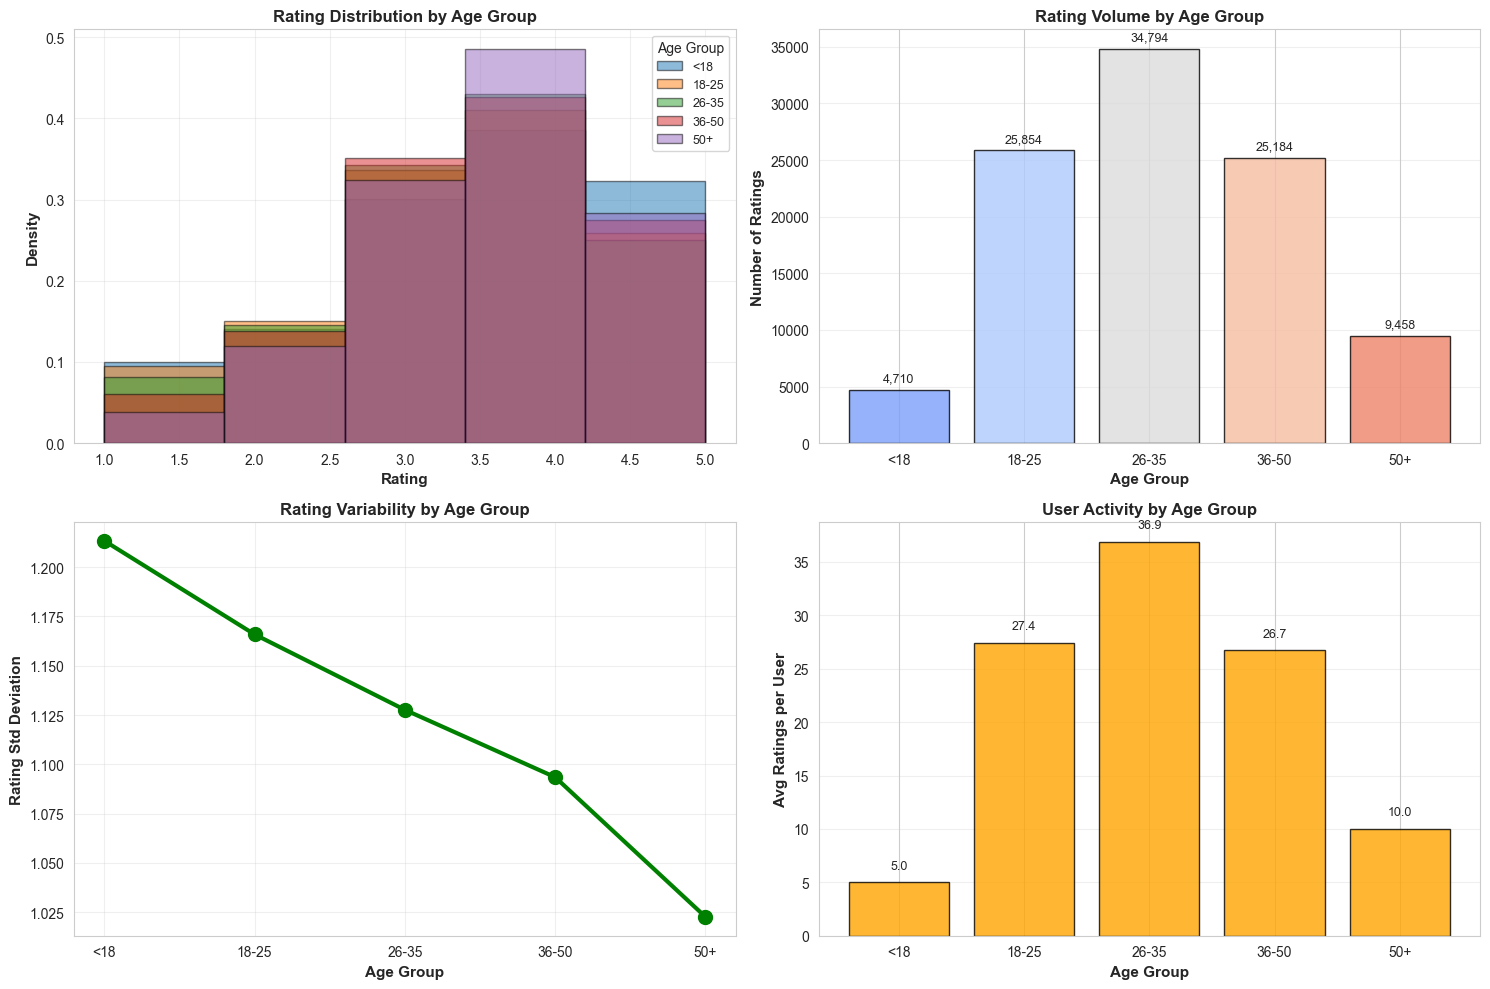

✓ Most active age group: 26-35 (34,794 ratings)
✓ Most variable ratings: <18 (std: 1.213)
✓ Highest ratings per user: 26-35 (36.9 ratings/user)


In [20]:
# Age Group Deep Dive
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Rating distribution by age group
for age_group in age_labels:
    age_group_data = user_ratings[user_ratings['age_group'] == age_group]['rating']
    axes[0, 0].hist(age_group_data, bins=5, alpha=0.5, label=age_group, 
                   edgecolor='black', density=True)

axes[0, 0].set_xlabel('Rating', fontsize=11, fontweight='bold')
axes[0, 0].set_ylabel('Density', fontsize=11, fontweight='bold')
axes[0, 0].set_title('Rating Distribution by Age Group', fontsize=12, fontweight='bold')
axes[0, 0].legend(title='Age Group', fontsize=9)
axes[0, 0].grid(alpha=0.3)

# Number of ratings by age group
age_group_rating_counts = user_ratings.groupby('age_group').size().sort_index()
colors_age_bars = plt.cm.coolwarm(np.linspace(0.2, 0.8, len(age_group_rating_counts)))
axes[0, 1].bar(range(len(age_group_rating_counts)), age_group_rating_counts.values, 
              color=colors_age_bars, edgecolor='black', alpha=0.8)
axes[0, 1].set_xticks(range(len(age_group_rating_counts)))
axes[0, 1].set_xticklabels(age_group_rating_counts.index, fontsize=10)
axes[0, 1].set_xlabel('Age Group', fontsize=11, fontweight='bold')
axes[0, 1].set_ylabel('Number of Ratings', fontsize=11, fontweight='bold')
axes[0, 1].set_title('Rating Volume by Age Group', fontsize=12, fontweight='bold')
axes[0, 1].grid(axis='y', alpha=0.3)

# Add value labels
for i, v in enumerate(age_group_rating_counts.values):
    axes[0, 1].text(i, v + 500, f'{v:,}', ha='center', va='bottom', fontsize=9)

# Rating generosity by age group (std dev)
age_group_std = user_ratings.groupby('age_group')['rating'].std().sort_index()
axes[1, 0].plot(range(len(age_group_std)), age_group_std.values, 
               color='green', linewidth=3, marker='o', markersize=10)
axes[1, 0].set_xticks(range(len(age_group_std)))
axes[1, 0].set_xticklabels(age_group_std.index, fontsize=10)
axes[1, 0].set_xlabel('Age Group', fontsize=11, fontweight='bold')
axes[1, 0].set_ylabel('Rating Std Deviation', fontsize=11, fontweight='bold')
axes[1, 0].set_title('Rating Variability by Age Group', fontsize=12, fontweight='bold')
axes[1, 0].grid(alpha=0.3)

# Average ratings per user by age group
ratings_per_user_by_age = user_ratings.groupby(['age_group', 'user_id']).size().groupby('age_group').mean().sort_index()
axes[1, 1].bar(range(len(ratings_per_user_by_age)), ratings_per_user_by_age.values, 
              color='orange', edgecolor='black', alpha=0.8)
axes[1, 1].set_xticks(range(len(ratings_per_user_by_age)))
axes[1, 1].set_xticklabels(ratings_per_user_by_age.index, fontsize=10)
axes[1, 1].set_xlabel('Age Group', fontsize=11, fontweight='bold')
axes[1, 1].set_ylabel('Avg Ratings per User', fontsize=11, fontweight='bold')
axes[1, 1].set_title('User Activity by Age Group', fontsize=12, fontweight='bold')
axes[1, 1].grid(axis='y', alpha=0.3)

# Add value labels
for i, v in enumerate(ratings_per_user_by_age.values):
    axes[1, 1].text(i, v + 1, f'{v:.1f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

print(f"✓ Most active age group: {age_group_rating_counts.idxmax()} ({age_group_rating_counts.max():,} ratings)")
print(f"✓ Most variable ratings: {age_group_std.idxmax()} (std: {age_group_std.max():.3f})")
print(f"✓ Highest ratings per user: {ratings_per_user_by_age.idxmax()} ({ratings_per_user_by_age.max():.1f} ratings/user)")

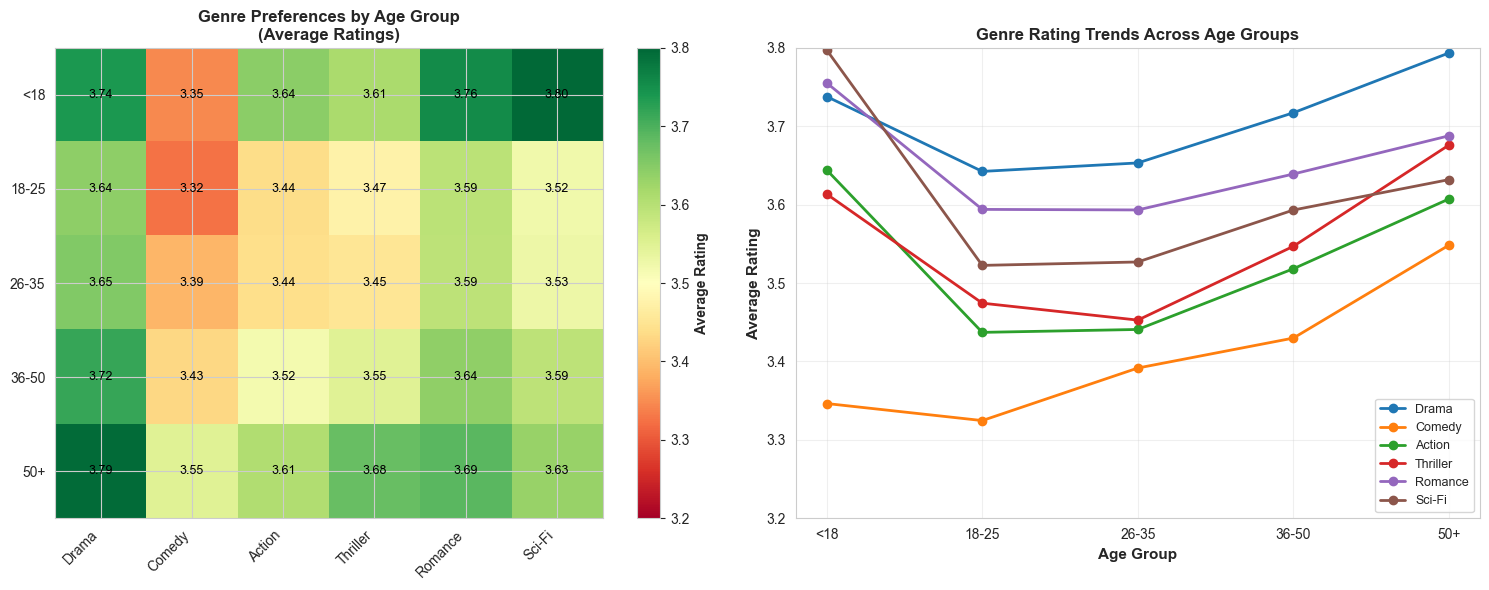


📊 Genre Champions by Age Group:
  • <18: Sci-Fi (3.797⭐)
  • 18-25: Drama (3.642⭐)
  • 26-35: Drama (3.653⭐)
  • 36-50: Drama (3.717⭐)
  • 50+: Drama (3.793⭐)


In [23]:
# Genre Preferences by Age Group
# Merge ratings with movies (for genres) and users (for age_group)
ratings_with_demographics = ratings.merge(users, on='user_id').merge(
    movies[['movie_id'] + genre_columns], left_on='item_id', right_on='movie_id')

top_genres_list = ['Drama', 'Comedy', 'Action', 'Thriller', 'Romance', 'Sci-Fi']
age_genre_prefs = {}

for genre in top_genres_list:
    age_genre_prefs[genre] = {}
    for age_group in age_labels:
        genre_data = ratings_with_demographics[(ratings_with_demographics[genre] == 1) & 
                                                (ratings_with_demographics['age_group'] == age_group)]
        if len(genre_data) > 0:
            age_genre_prefs[genre][age_group] = genre_data['rating'].mean()
        else:
            age_genre_prefs[genre][age_group] = np.nan

age_genre_df = pd.DataFrame(age_genre_prefs)

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Heatmap
im = axes[0].imshow(age_genre_df.values, cmap='RdYlGn', aspect='auto', vmin=3.2, vmax=3.8)
axes[0].set_xticks(range(len(age_genre_df.columns)))
axes[0].set_xticklabels(age_genre_df.columns, fontsize=10, rotation=45, ha='right')
axes[0].set_yticks(range(len(age_genre_df.index)))
axes[0].set_yticklabels(age_genre_df.index, fontsize=10)
axes[0].set_title('Genre Preferences by Age Group\n(Average Ratings)', fontsize=12, fontweight='bold')

# Add text annotations
for i in range(len(age_genre_df.index)):
    for j in range(len(age_genre_df.columns)):
        if not np.isnan(age_genre_df.values[i, j]):
            text = axes[0].text(j, i, f'{age_genre_df.values[i, j]:.2f}',
                              ha='center', va='center', color='black', fontsize=9)

# Add colorbar
cbar = plt.colorbar(im, ax=axes[0])
cbar.set_label('Average Rating', fontsize=10, fontweight='bold')

# Line plot for trends
for col in age_genre_df.columns:
    axes[1].plot(range(len(age_genre_df)), age_genre_df[col].values, 
                marker='o', linewidth=2, label=col, markersize=6)

axes[1].set_xticks(range(len(age_genre_df)))
axes[1].set_xticklabels(age_genre_df.index, fontsize=10)
axes[1].set_xlabel('Age Group', fontsize=11, fontweight='bold')
axes[1].set_ylabel('Average Rating', fontsize=11, fontweight='bold')
axes[1].set_title('Genre Rating Trends Across Age Groups', fontsize=12, fontweight='bold')
axes[1].legend(loc='best', fontsize=9)
axes[1].grid(alpha=0.3)
axes[1].set_ylim(3.2, 3.8)

plt.tight_layout()
plt.show()

# Find which age group likes which genre most
print("\n📊 Genre Champions by Age Group:")
for age_group in age_labels:
    best_genre = age_genre_df.loc[age_group].idxmax()
    best_rating = age_genre_df.loc[age_group].max()
    print(f"  • {age_group}: {best_genre} ({best_rating:.3f}⭐)")

AttributeError: Can only use .dt accessor with datetimelike values

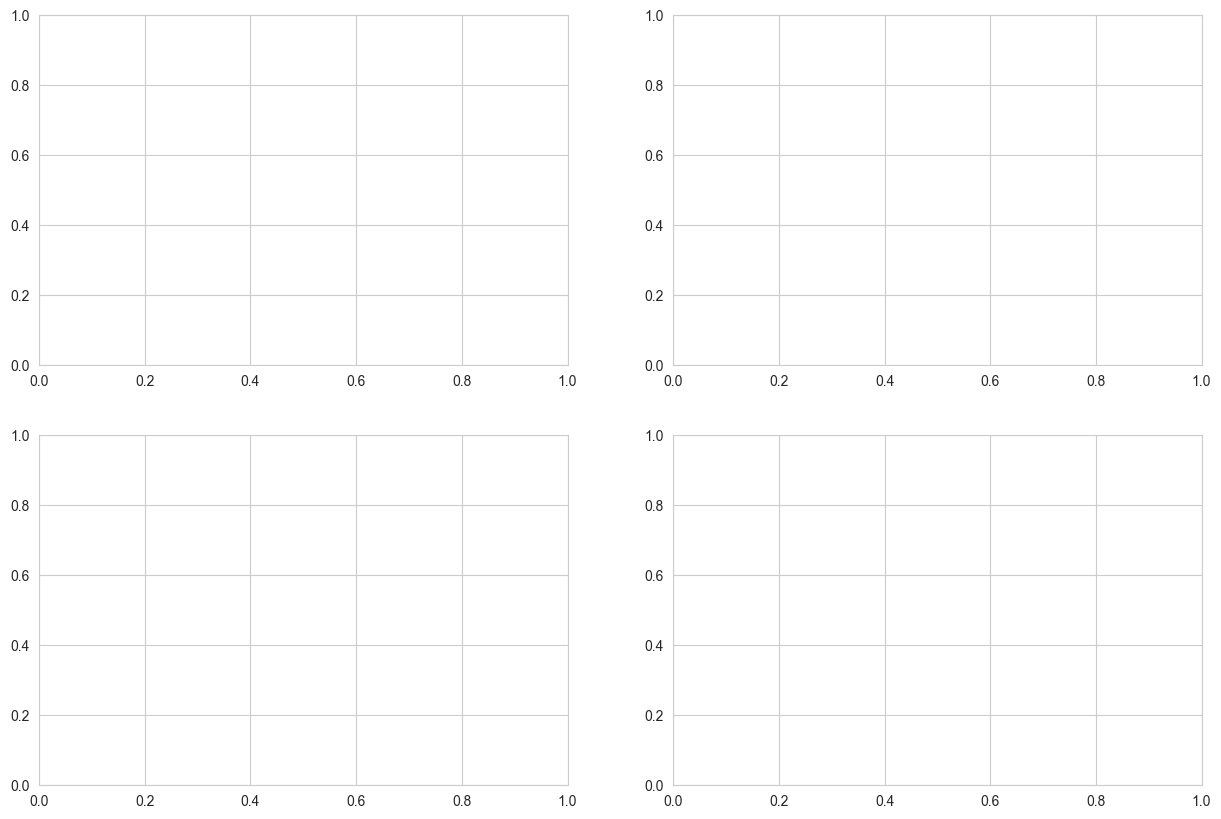

In [ ]:
# Temporal Analysis - Ratings Over Time
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Ratings by month
ratings['year_month'] = ratings['datetime'].dt.to_period('M')
monthly_ratings = ratings.groupby('year_month').size()
monthly_ratings_dates = [period.to_timestamp() for period in monthly_ratings.index]

axes[0, 0].plot(monthly_ratings_dates, monthly_ratings.values, color='steelblue', linewidth=2)
axes[0, 0].fill_between(monthly_ratings_dates, monthly_ratings.values, alpha=0.3, color='steelblue')
axes[0, 0].set_xlabel('Date', fontsize=11, fontweight='bold')
axes[0, 0].set_ylabel('Number of Ratings', fontsize=11, fontweight='bold')
axes[0, 0].set_title('Ratings Over Time (Monthly)', fontsize=12, fontweight='bold')
axes[0, 0].grid(alpha=0.3)
axes[0, 0].tick_params(axis='x', rotation=45)

# Average rating over time
monthly_avg_ratings = ratings.groupby('year_month')['rating'].mean()
axes[0, 1].plot(monthly_ratings_dates, monthly_avg_ratings.values, 
               color='coral', linewidth=2, marker='o', markersize=4)
axes[0, 1].axhline(ratings['rating'].mean(), color='red', linestyle='--', 
                   linewidth=2, label=f'Overall Avg: {ratings["rating"].mean():.3f}')
axes[0, 1].set_xlabel('Date', fontsize=11, fontweight='bold')
axes[0, 1].set_ylabel('Average Rating', fontsize=11, fontweight='bold')
axes[0, 1].set_title('Average Rating Over Time', fontsize=12, fontweight='bold')
axes[0, 1].set_ylim(3, 4)
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)
axes[0, 1].tick_params(axis='x', rotation=45)

# Ratings by day of week
ratings['day_of_week'] = ratings['datetime'].dt.day_name()
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
day_counts = ratings.groupby('day_of_week').size().reindex(day_order)
colors_day = plt.cm.viridis(np.linspace(0.2, 0.8, len(day_counts)))

axes[1, 0].bar(range(len(day_counts)), day_counts.values, 
              color=colors_day, edgecolor='black', alpha=0.8)
axes[1, 0].set_xticks(range(len(day_counts)))
axes[1, 0].set_xticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'], fontsize=10)
axes[1, 0].set_xlabel('Day of Week', fontsize=11, fontweight='bold')
axes[1, 0].set_ylabel('Number of Ratings', fontsize=11, fontweight='bold')
axes[1, 0].set_title('Rating Activity by Day of Week', fontsize=12, fontweight='bold')
axes[1, 0].grid(axis='y', alpha=0.3)

# Add value labels
for i, v in enumerate(day_counts.values):
    axes[1, 0].text(i, v + 100, f'{v:,}', ha='center', va='bottom', fontsize=9)

# Ratings by hour of day
ratings['hour'] = ratings['datetime'].dt.hour
hourly_counts = ratings.groupby('hour').size()
colors_hour = plt.cm.plasma(hourly_counts.values / hourly_counts.max())

axes[1, 1].bar(hourly_counts.index, hourly_counts.values, 
              color=colors_hour, edgecolor='black', alpha=0.8)
axes[1, 1].set_xlabel('Hour of Day', fontsize=11, fontweight='bold')
axes[1, 1].set_ylabel('Number of Ratings', fontsize=11, fontweight='bold')
axes[1, 1].set_title('Rating Activity by Hour', fontsize=12, fontweight='bold')
axes[1, 1].set_xticks(range(0, 24, 2))
axes[1, 1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print(f"✓ Time period: {ratings['datetime'].min().date()} to {ratings['datetime'].max().date()}")
print(f"✓ Most active day: {day_counts.idxmax()} ({day_counts.max():,} ratings)")
print(f"✓ Peak hour: {hourly_counts.idxmax()}:00 ({hourly_counts.max():,} ratings)")
print(f"✓ Busiest month: {monthly_ratings.idxmax()} ({monthly_ratings.max():,} ratings)")

KeyError: 'age_group'